In [7]:
import cvxopt
import numpy as np

class SupportVectorMachine:
    '''
    Binary Classifier using Support Vector Machine
    '''
    def __init__(self):
        self.alpha = None
        self.w = None
        self.b = None
        self.X_train = None
        self.y_train = None
        self.gamma = None
        
    def gaussian_kernel(self,X1, X2, gamma):
        '''
        Compute the Gaussian kernel matrix between X1 and X2 efficiently.
        
        Args:
            X1: np.array of shape (N1, D)
            X2: np.array of shape (N2, D)
            gamma: float, gamma parameter for the Gaussian kernel
            
        Returns:
            Kernel matrix of shape (N1, N2)
        '''
        self.gamma = gamma
        # Compute squared Euclidean distances efficiently
        X1_norm = np.sum(X1**2, axis=1).reshape(-1, 1)
        X2_norm = np.sum(X2**2, axis=1).reshape(1, -1)
        distances = X1_norm + X2_norm - 2 * np.dot(X1, X2.T)
        
        # Compute the Gaussian kernel
        K = np.exp(-gamma * distances)
        return K
        
    def fit(self, X, y, kernel = 'linear', C = 1.0, gamma = 0.001):
        '''
        Learn the parameters from the given training data
        Classes are 0 or 1
        
        Args:
            X: np.array of shape (N, D) 
                where N is the number of samples and D is the flattened dimension of each image
                
            y: np.array of shape (N,)
                where N is the number of samples and y[i] is the class of the ith sample
                
            kernel: str
                The kernel to be used. Can be 'linear' or 'gaussian'
                
            C: float
                The regularization parameter
                
            gamma: float
                The gamma parameter for gaussian kernel, ignored for linear kernel
        '''
        N, D = X.shape
        y = y.astype(np.double).reshape(-1, 1) 
        
        # Compute Gram matrix (for linear kernel)
        if kernel == 'linear':
            K = X @ X.T
        elif kernel == 'gaussian':
            K = self.gaussian_kernel(X, X, gamma)
        
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-np.ones((N, 1)))
        G = cvxopt.matrix(np.vstack((-np.eye(N), np.eye(N))))
        h = cvxopt.matrix(np.hstack((np.zeros(N), np.ones(N) * C)))
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(0.0)

        # Solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(solution['x'])
        
        # Select support vectors
        sv = alpha > 1e-5
        self.alpha = alpha[sv]
        self.X_train = X[sv]
        self.y_train = y[sv]

        # Compute w and b for linear kernel
        if kernel == 'linear':
            self.w = np.sum(self.alpha[:, None] * self.y_train * self.X_train, axis=0)
            self.b = np.mean(self.y_train - (self.w @ self.X_train.T))
        elif kernel == 'gaussian':
            # Compute bias term (b) for Gaussian kernel
            sv_indices = np.where(sv)[0]
            self.b = 0
            for i in range(len(self.alpha)):
                self.b += self.y_train[i] - np.sum(self.alpha * self.y_train * K[sv_indices[i], sv])
            self.b /= len(self.alpha)
            
        num_support_vectors = np.sum(sv)
        support_vector_percentage = (num_support_vectors / len(y)) * 100
        print(f"Number of Support Vectors: {num_support_vectors}")
        print(f"Percentage of Support Vectors: {support_vector_percentage:.2f}%")
        
        
    def predict(self, X):
        '''
        Predict the class of the input data
        
        Args:
            X: np.array of shape (N, D) 
                where N is the number of samples and D is the flattened dimension of each image
                
        Returns:
            np.array of shape (N,)
                where N is the number of samples and y[i] is the class of the
                ith sample (0 or 1)
        '''
        
        if self.w is not None:  # Linear Kernel
            print(self.w)
            print(self.b)
            return (X @ self.w + self.b >= 0).astype(int)
        # Gaussian Kernel (optimized computation)
        gamma = self.gamma  # Ensure gamma is set correctly
        X_norm = np.sum(X**2, axis=1).reshape(-1, 1)  # (N_test, 1)
        sv_norm = np.sum(self.X_train**2, axis=1).reshape(1, -1)  # (1, N_train)
        print(self.w)
        print(self.b)
        # Compute Gaussian Kernel correctly (N_test, N_train)
        K = np.exp(-gamma * (X_norm + sv_norm - 2 * np.dot(X, self.X_train.T))) - self.b  # (N_test, N_train)
        
        # Ensure correct broadcasting
        decision_values = np.sum((self.alpha * self.y_train.T) * K, axis=1)  # (N_test,)
        
        return (decision_values >= 0).astype(int)

In [3]:
import os
import cv2
import numpy as np

def load_images_from_folder(base_path):
    data = []
    labels = []
    
    classes = sorted(os.listdir(base_path))  # Get class labels
    for class_index, class_name in enumerate(classes):
        class_folder = os.path.join(base_path, class_name)
        image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.jpg')]

        for img_path in image_files:
            img = cv2.imread(img_path)  # Load image
            if img is None:
                continue  # Skip this image

            img = cv2.resize(img, (100, 100))  # Resize to 100x100
            img = img / 255.0  # Normalize to [0, 1]
            img = img.flatten()  # Flatten to 30,000 features
            
            data.append(img)
            labels.append(class_index)

    return np.array(data), np.array(labels)

# Load Train & Test Data
train_data, train_labels = load_images_from_folder("../data/Q2/train")
test_data, test_labels = load_images_from_folder("../data/Q2/test")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [5]:
d = 27
class_1 = d % 11
class_2 = (d + 1) % 11

# Filter dataset to keep only two selected classes
binary_train_mask = (train_labels == class_1) | (train_labels == class_2)
binary_test_mask = (test_labels == class_1) | (test_labels == class_2)

X_train, y_train = train_data[binary_train_mask], train_labels[binary_train_mask]
X_test, y_test = test_data[binary_test_mask], test_labels[binary_test_mask]

# Convert labels to {+1, -1} for SVM
y_train = np.where(y_train == class_1, 1, -1)
y_test = np.where(y_test == class_1, 1, -1)


In [8]:
# Create SVM instance
svm_linear = SupportVectorMachine()

# Train SVM on training data (Only binary classification: class_1 vs class_2)
svm_linear.fit(X_train, y_train, kernel='linear', C=1.0)

# Predict on train data
y_pred_train = svm_linear.predict(X_train)

# Predict on test data
y_pred = svm_linear.predict(X_test)

# Compute accuracy
accuracy_train = np.mean(y_pred_train == (y_train == 1)) * 100
accuracy = np.mean(y_pred == (y_test == 1)) * 100
print(f"Train Accuracy: {accuracy_train:.2f}%")
print(f"Test Accuracy: {accuracy:.2f}%")


     pcost       dcost       gap    pres   dres
 0: -2.3858e-01 -7.6437e+02  3e+03  1e+00  4e-12
 1:  1.0436e+00 -2.4791e+02  4e+02  1e-01  4e-12
 2:  5.5629e-01 -8.0987e+01  1e+02  2e-02  3e-12
 3: -4.3595e-02 -3.7545e+01  5e+01  9e-03  2e-12
 4: -3.1378e-01 -1.2921e+01  2e+01  2e-03  2e-12
 5: -3.6100e-01 -2.4909e+00  2e+00  2e-04  1e-12
 6: -4.5768e-01 -7.5809e-01  3e-01  2e-05  8e-13
 7: -4.9419e-01 -5.5554e-01  6e-02  2e-06  7e-13
 8: -5.0715e-01 -5.1691e-01  1e-02  9e-08  7e-13
 9: -5.0982e-01 -5.1049e-01  7e-04  4e-09  8e-13
10: -5.1004e-01 -5.1006e-01  2e-05  8e-11  8e-13
11: -5.1005e-01 -5.1005e-01  4e-07  1e-12  7e-13
Optimal solution found.
Number of Support Vectors: 277
Percentage of Support Vectors: 38.42%
[0.0037009  0.00107504 0.0062305  ... 0.01331021 0.00834421 0.00651059]
0.33135992018949695
[0.0037009  0.00107504 0.0062305  ... 0.01331021 0.00834421 0.00651059]
0.33135992018949695
Train Accuracy: 100.00%
Test Accuracy: 87.36%


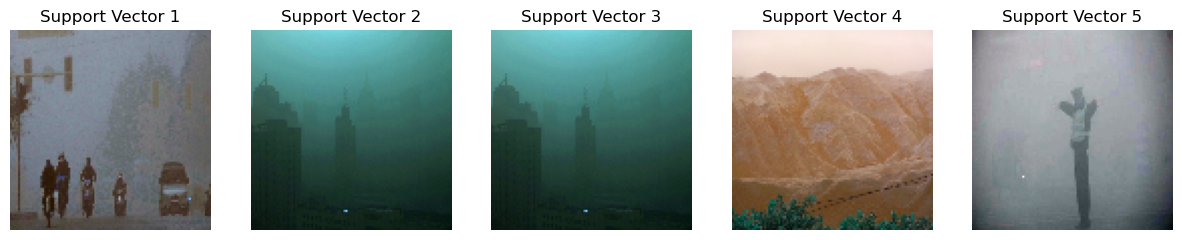

In [21]:
import matplotlib.pyplot as plt

# Get top-5 support vectors (highest alphas)
top_5_indices = np.argsort(svm_linear.alpha)[-5:]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(top_5_indices):
    img = svm_linear.X_train[idx].reshape(100, 100, 3)  # Reshape to image dimensions
    img = (img - img.min()) / (img.max() - img.min())
    axes[i].imshow(img)
    axes[i].set_title(f"Support Vector {i+1}")
    axes[i].axis('off')
plt.show()


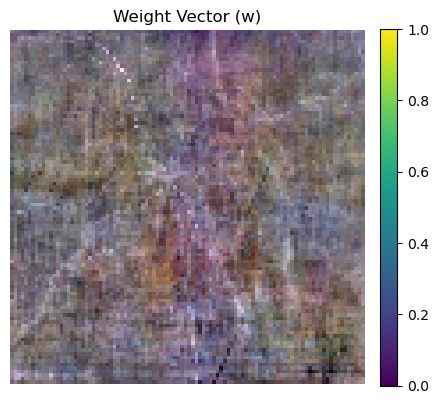

In [9]:
import matplotlib.pyplot as plt

# Reshape the weight vector w to (100, 100, 3)
w_img = svm_linear.w.reshape(100, 100, 3)

# Normalize w_img to [0, 1] for visualization
w_img = (w_img - w_img.min()) / (w_img.max() - w_img.min())

# Plot the weight vector
plt.figure(figsize=(5, 5))
im=plt.imshow(w_img)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Weight Vector (w)")
plt.axis('off')
plt.show()

part 2

In [10]:
# Create SVM instance
svm_gaussian = SupportVectorMachine()

# Train SVM using Gaussian Kernel
svm_gaussian.fit(X_train, y_train, kernel='gaussian', C=1, gamma=0.001)

# Predict on train set
y_pred_train = svm_gaussian.predict(X_train)

# Predict on test set
y_pred_gaussian = svm_gaussian.predict(X_test)

# Compute accuracy
accuracy_train_gaussian = np.mean(y_pred_train == (y_train == 1)) * 100
accuracy_gaussian = np.mean(y_pred_gaussian == (y_test == 1)) * 100
print(f"Train Accuracy (Gaussian Kernel): {accuracy_train_gaussian:.2f}%")
print(f"Test Accuracy (Gaussian Kernel): {accuracy_gaussian:.2f}%")


     pcost       dcost       gap    pres   dres
 0: -1.1526e+02 -1.4047e+03  6e+03  2e+00  2e-15
 1: -8.8718e+01 -8.1145e+02  8e+02  9e-02  2e-15
 2: -1.0530e+02 -2.2005e+02  1e+02  1e-02  2e-15
 3: -1.1516e+02 -1.5951e+02  4e+01  3e-03  1e-15
 4: -1.2036e+02 -1.2749e+02  7e+00  3e-04  1e-15
 5: -1.2169e+02 -1.2283e+02  1e+00  2e-05  1e-15
 6: -1.2193e+02 -1.2209e+02  2e-01  3e-06  1e-15
 7: -1.2197e+02 -1.2198e+02  9e-03  4e-08  2e-15
 8: -1.2198e+02 -1.2198e+02  2e-04  7e-10  2e-15
 9: -1.2198e+02 -1.2198e+02  6e-06  7e-12  2e-15
Optimal solution found.
Number of Support Vectors: 469
Percentage of Support Vectors: 65.05%
None
[1346.49360948]
None
[1346.49360948]
Train Accuracy (Gaussian Kernel): 98.06%
Test Accuracy (Gaussian Kernel): 83.52%


In [12]:
import numpy as np

# Retrieve support vectors for both models
sv_linear = svm_linear.X_train  # Support vectors for linear kernel
sv_gaussian = svm_gaussian.X_train  # Support vectors for Gaussian kernel

# Use numpy broadcasting to check common support vectors
common_support_vectors = np.array([np.any(np.all(np.isclose(sv, sv_gaussian, atol=1e-5), axis=1)) for sv in sv_linear])

# Count the number of common support vectors
num_common_sv = np.sum(common_support_vectors)

print(f"Number of Common Support Vectors: {num_common_sv}")

Number of Common Support Vectors: 225


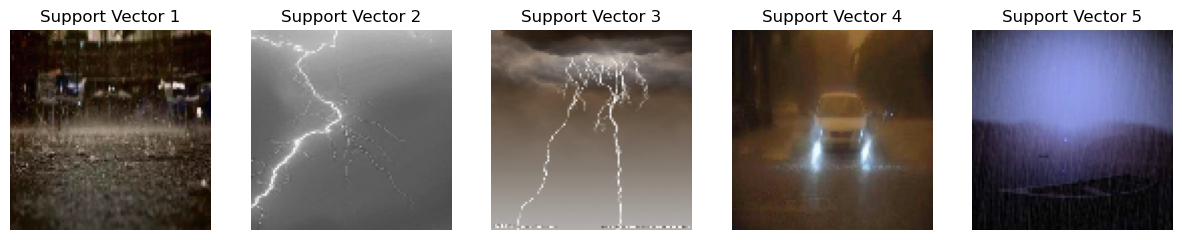

In [10]:
import matplotlib.pyplot as plt

# Get top-5 support vectors (highest alphas)
top_5_indices = np.argsort(svm_gaussian.alpha)[-5:]

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(top_5_indices):
    img = svm_gaussian.X_train[idx].reshape(100, 100, 3)  # Reshape to image dimensions
    axes[i].imshow(img)
    axes[i].set_title(f"Support Vector {i+1}")
    axes[i].axis('off')
plt.show()


part 3


In [23]:
from sklearn.svm import SVC
import time

# Train Linear SVM
start_time = time.time()
svm_sklearn_linear = SVC(kernel='linear', C=1.0)
svm_sklearn_linear.fit(X_train, y_train)
end_time = time.time()
train_time_linear = end_time - start_time
print(f"Training Time (Linear Kernel, scikit-learn): {train_time_linear:.4f} sec")

# Train Gaussian (RBF) Kernel SVM
start_time = time.time()
svm_sklearn_gaussian = SVC(kernel='rbf', C=1.0, gamma=0.001)
svm_sklearn_gaussian.fit(X_train, y_train)
end_time = time.time()
train_time_gaussian = end_time - start_time
print(f"Training Time (Gaussian Kernel, scikit-learn): {train_time_gaussian:.4f} sec")


Training Time (Linear Kernel, scikit-learn): 8.9087 sec
Training Time (Gaussian Kernel, scikit-learn): 7.3909 sec


In [12]:
num_sv_linear_sklearn = len(svm_sklearn_linear.support_)
num_sv_gaussian_sklearn = len(svm_sklearn_gaussian.support_)

print(f"Number of Support Vectors (scikit-learn, Linear): {num_sv_linear_sklearn}")
print(f"Number of Support Vectors (scikit-learn, Gaussian): {num_sv_gaussian_sklearn}")


Number of Support Vectors (scikit-learn, Linear): 270
Number of Support Vectors (scikit-learn, Gaussian): 457


In [14]:
# Extract weights and bias for scikit-learn linear SVM
w_sklearn = svm_sklearn_linear.coef_
b_sklearn = svm_sklearn_linear.intercept_

# Extract weights and bias for cvxopt linear SVM
w_cvxopt = svm_linear.w
b_cvxopt = svm_linear.b

print(f"Weight Vector (CVXOPT, Linear): {w_cvxopt}")
print(f"Weight Vector (scikit-learn, Linear): {w_sklearn}")

print(f"Bias Term (CVXOPT, Linear): {b_cvxopt}")
print(f"Bias Term (scikit-learn, Linear): {b_sklearn}")


Weight Vector (CVXOPT, Linear): [0.0037009  0.00107504 0.0062305  ... 0.01331021 0.00834421 0.00651059]
Weight Vector (scikit-learn, Linear): [[0.00369389 0.00106781 0.00622247 ... 0.01330205 0.00834314 0.00650818]]
Bias Term (CVXOPT, Linear): 0.33135992018949695
Bias Term (scikit-learn, Linear): [0.41278837]


In [24]:
# Predict using scikit-learn
y_pred_sklearn_linear = svm_sklearn_linear.predict(X_test)
y_pred_sklearn_gaussian = svm_sklearn_gaussian.predict(X_test)

# Compute accuracy
accuracy_sklearn_linear = np.mean(y_pred_sklearn_linear == y_test) * 100
accuracy_sklearn_gaussian = np.mean(y_pred_sklearn_gaussian == y_test) * 100

print(f"Test Accuracy (scikit-learn, Linear): {accuracy_sklearn_linear:.2f}%")
print(f"Test Accuracy (scikit-learn, Gaussian): {accuracy_sklearn_gaussian:.2f}%")


Test Accuracy (scikit-learn, Linear): 72.18%
Test Accuracy (scikit-learn, Gaussian): 95.86%


part 4


In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import time

# Train SVM using SGD
sgd_svm = SGDClassifier(loss='hinge', alpha=1e-3, max_iter=1000, tol=1e-3, random_state=42)

start_time = time.time()
sgd_svm.fit(X_train, y_train)  # Train on training data
sgd_train_time = time.time() - start_time

# Predict on test data
y_pred_sgd = sgd_svm.predict(X_test)

# Calculate accuracy
sgd_accuracy = accuracy_score(y_test, y_pred_sgd)

print(f"SGD Training Time: {sgd_train_time:.4f} seconds")
print(f"SGD Test Accuracy: {sgd_accuracy:.4f}")


SGD Training Time: 0.7221 seconds
SGD Test Accuracy: 0.9341
